[nltk_data] Downloading package wordnet to /root/nltk_data...


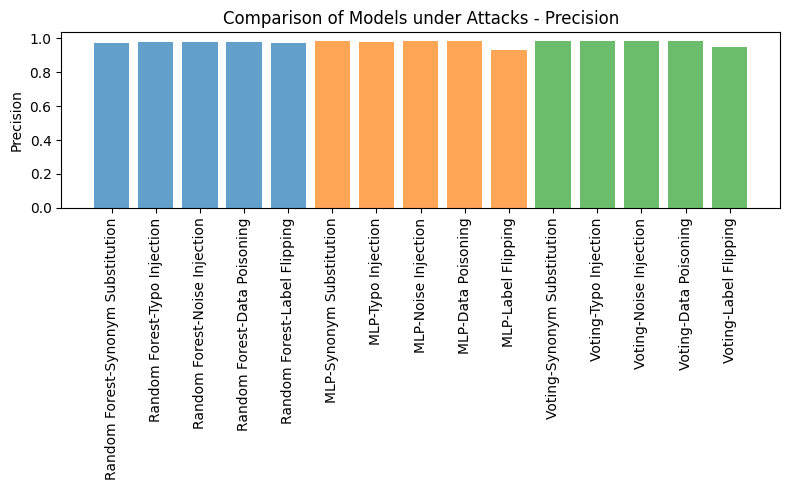

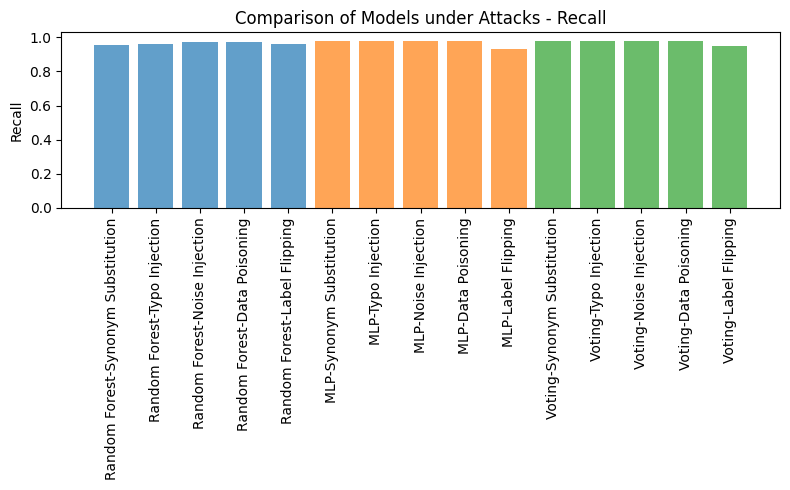

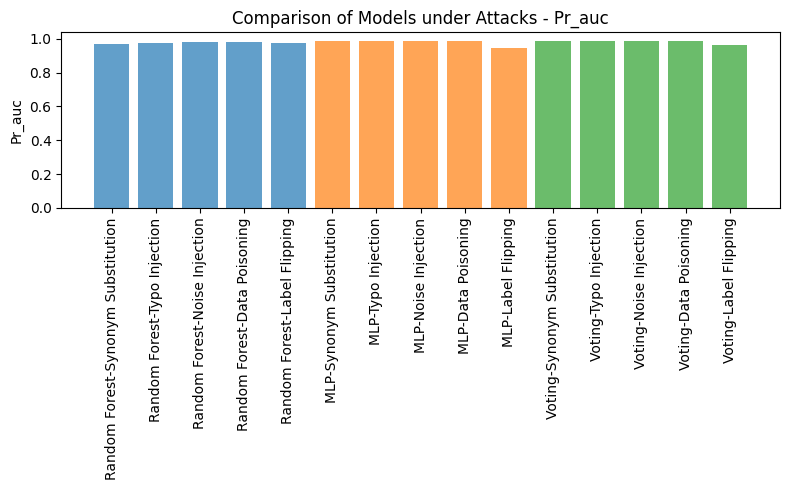

In [1]:
# ================================
# SMS Adversarial Attack Pipeline
# Models: RF, MLP, Voting
# ================================

import pandas as pd
import numpy as np
import random
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, precision_recall_curve, auc
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')

# -------------------------
# Load Dataset
# -------------------------
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sms.csv")
X = df['Messages']
y = df['Label']

# -------------------------
# Train/Test Split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------
# TF-IDF Vectorization
# -------------------------
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# -------------------------
# Define Models
# -------------------------
rf = RandomForestClassifier(n_estimators=100, random_state=42)
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
voting = VotingClassifier(estimators=[('rf', rf), ('mlp', mlp)], voting='soft')

models = {
    'Random Forest': rf,
    'MLP': mlp,
    'Voting': voting
}

# -------------------------
# Attack Functions
# -------------------------
def synonym_substitution(text):
    words = text.split()
    new_words = []
    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            lemmas = synonyms[0].lemma_names()
            if lemmas:
                new_words.append(random.choice(lemmas))
            else:
                new_words.append(word)
        else:
            new_words.append(word)
    return " ".join(new_words)

def typo_injection(text):
    words = text.split()
    for i in range(len(words)):
        if random.random() < 0.1:
            word = list(words[i])
            if len(word) > 1:
                idx = random.randint(0, len(word)-2)
                word[idx], word[idx+1] = word[idx+1], word[idx]
            words[i] = ''.join(word)
    return " ".join(words)

def noise_injection(text):
    noise_chars = string.punctuation
    return text + " " + "".join(random.choices(noise_chars, k=3))

def data_poisoning(X_data):
    poisoned = X_data.copy()
    for i in range(len(poisoned)):
        if random.random() < 0.1:
            poisoned[i] = "spammyword " + poisoned[i]
    return poisoned

def label_flipping(y_data):
    flipped = y_data.copy()
    unique_labels = y_data.unique()
    for i in range(len(flipped)):
        if random.random() < 0.1:
            flipped.iloc[i] = random.choice(unique_labels)
    return flipped

# -------------------------
# Apply Attacks and Evaluate
# -------------------------
attack_funcs = {
    'Synonym Substitution': lambda X, y: (X.apply(synonym_substitution), y),
    'Typo Injection': lambda X, y: (X.apply(typo_injection), y),
    'Noise Injection': lambda X, y: (X.apply(noise_injection), y),
    'Data Poisoning': lambda X, y: (pd.Series(data_poisoning(list(X))), y),
    'Label Flipping': lambda X, y: (X, label_flipping(y))
}

results = {m: {} for m in models}

for model_name, model in models.items():
    for attack_name, attack_func in attack_funcs.items():
        # Apply attack
        X_attacked, y_attacked = attack_func(X_train.copy(), y_train.copy())

        # Vectorize attacked data
        X_train_vec_attacked = vectorizer.fit_transform(X_attacked)
        X_test_vec_attacked = vectorizer.transform(X_test)

        # Train model
        model.fit(X_train_vec_attacked, y_attacked)

        # Predict
        y_pred = model.predict(X_test_vec_attacked)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

        # Store metrics
        precision, recall, _ = precision_recall_curve(pd.get_dummies(y_test).values.ravel(),
                                                      pd.get_dummies(y_pred).values.ravel())
        pr_auc = auc(recall, precision)

        results[model_name][attack_name] = {
            'precision': np.mean([v['precision'] for k, v in report.items() if k in df['Label'].unique()]),
            'recall': np.mean([v['recall'] for k, v in report.items() if k in df['Label'].unique()]),
            'pr_auc': pr_auc
        }

# -------------------------
# Plot Results
# -------------------------
for metric in ['precision', 'recall', 'pr_auc']:
    plt.figure(figsize=(8, 5))
    for model_name in models:
        plt.bar(
            [f"{model_name}-{attack}" for attack in attack_funcs.keys()],
            [results[model_name][attack][metric] for attack in attack_funcs.keys()],
            alpha=0.7
        )
    plt.xticks(rotation=90)
    plt.ylabel(metric.capitalize())
    plt.title(f"Comparison of Models under Attacks - {metric.capitalize()}")
    plt.tight_layout()
    plt.show()


In [5]:
import pandas as pd

# Create a DataFrame to store results
metrics_table = pd.DataFrame(columns=["Model", "Attack", "Precision", "Recall", "AUC"]).astype({
    "Model": str,
    "Attack": str,
    "Precision": float,
    "Recall": float,
    "AUC": float
})


# Loop through results dictionary and store metrics
for model_name, attack_results in results.items():
    for attack_name, metrics in attack_results.items():
        metrics_table = pd.concat([
            metrics_table,
            pd.DataFrame([{
                "Model": model_name,
                "Attack": attack_name,
                "Precision": metrics["precision"],
                "Recall": metrics["recall"],
                "AUC": metrics["pr_auc"]
            }])
        ], ignore_index=True)

# Display the table
display(metrics_table)

# Also print it for console
print(metrics_table)

,Model,Attack,Precision,Recall,AUC
0,Random Forest,Synonym Substitution,0.973388,0.952442,0.970344
1,Random Forest,Typo Injection,0.977779,0.962994,0.977017
2,Random Forest,Noise Injection,0.980166,0.970532,0.981465
3,Random Forest,Data Poisoning,0.980166,0.970532,0.981465
4,Random Forest,Label Flipping,0.969910,0.958976,0.972568
5,MLP,Synonym Substitution,0.984741,0.979658,0.986655
6,MLP,Typo Injection,0.981195,0.977983,0.985172
7,MLP,Noise Injection,0.983918,0.978402,0.986655
8,MLP,Data Poisoning,0.983938,0.978906,0.986655
9,MLP,Label Flipping,0.929590,0.928496,0.945136


            Model                Attack  Precision    Recall       AUC
0   Random Forest  Synonym Substitution   0.973388  0.952442  0.970344
1   Random Forest        Typo Injection   0.977779  0.962994  0.977017
2   Random Forest       Noise Injection   0.980166  0.970532  0.981465
3   Random Forest        Data Poisoning   0.980166  0.970532  0.981465
4   Random Forest        Label Flipping   0.969910  0.958976  0.972568
5             MLP  Synonym Substitution   0.984741  0.979658  0.986655
6             MLP        Typo Injection   0.981195  0.977983  0.985172
7             MLP       Noise Injection   0.983918  0.978402  0.986655
8             MLP        Data Poisoning   0.983938  0.978906  0.986655
9             MLP        Label Flipping   0.929590  0.928496  0.945136
10         Voting  Synonym Substitution   0.985796  0.978988  0.987396
11         Voting        Typo Injection   0.986389  0.980077  0.988138
12         Voting       Noise Injection   0.983918  0.978402  0.986655
13    